False
 Extra–inning rows: 4,645
[INFO] Pitch model rows kept: 1353 (dropped 0)
[INFO] Zone model rows kept: 1353 (dropped 0)
[AUDIT] NaN counts in pitch inputs: {'stand_enc': 0, 'count_enc': 0, 'arch_enc': 0, 'pitch_cluster_enc': 0}
[AUDIT] NaN counts in zone (pre-enc) inputs: {'pitch_cluster_enc': 0, 'count_enc': 0, 'stand_enc': 0, 'zone': 0}

===== AUDIT REPORT =====
Trials: 200
Hits — mean=1.420  P(0)=0.190  P(>=2)=0.425
PA — total=980  (SP=546, RP=418, EX=16)
BF — total=8419  (SP=4486, RP=3784, EX=149)
BIP — count=404  rate/PA=0.412  E[Hit|BIP]=0.389  Hit/PA=0.290
xBA — mean=0.354  min=0.353  max=0.367
Lookup usage — pitch: 282 hits / 1857 NB; zone: 0 / 2139; outcome: 461 / 1678
Lookup rejects — pitch:1083  zone:2068  outcome:1208
Foul breaker trips: 0
Aborts — max_pitches:0 timeout:0 no_progress:0
SP IP — mean=4.22  sd=1.27
SP BF — mean=22.43  sd=4.98
RP BF — mean=18.92  sd=6.65
EX BF — mean=0.74  sd=2.00
[INFO] Pitch model rows kept: 1353 (dropped 0)
[INFO] Zone model rows kept: 

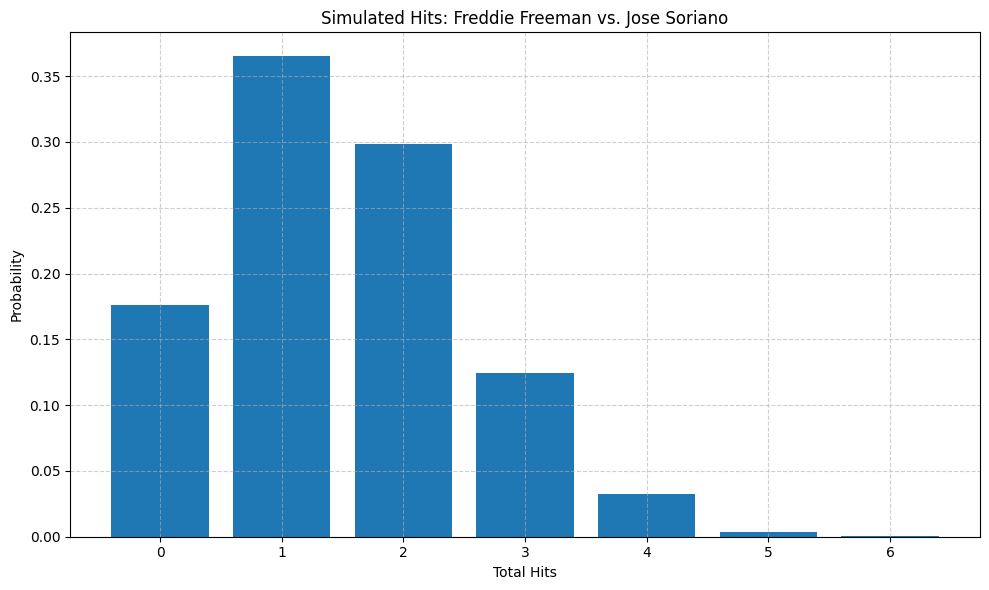

Results: Counter({1: 3650, 2: 2983, 0: 1758, 3: 1245, 4: 322, 5: 38, 6: 4})
Mean hits: 1.4853
Std dev: 1.047517846799727
P(0 hits): 0.1758
P(1+): 0.8242   P(2+): 0.4592


In [1]:
# mc_matchup.py
import types, joblib, numpy as np, pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB
import AtBatSim
from baseball_utils import *

def load_pack(path: str):
    return types.SimpleNamespace(**joblib.load(path))

# mc_audit_v2.py — focused PA & outcome audit for Monte Carlo + AtBatSim
import time, types, joblib, numpy as np, pandas as pd
from collections import Counter, defaultdict
from sklearn.naive_bayes import CategoricalNB
from baseball_utils import *
import AtBatSim
from General_Initialization import map_description_to_simple  # your mapper

# ===== Config =====
MIN_LOOKUP_SUPPORT = 3
MIN_LOOKUP_DOMINANCE = 0.70
FOUL_STREAK_CAP = 10

# ===== Small helpers =====
def _encode_count(balls, strikes):
    table = {(0,0):0,(0,1):1,(0,2):2,(1,0):3,(1,1):4,(1,2):5,(2,0):6,(2,1):7,(2,2):8,(3,0):9,(3,1):10,(3,2):11}
    return table.get((int(balls), int(strikes)), 0)

def _lookup_is_trustworthy(counter: Counter, *, min_support=MIN_LOOKUP_SUPPORT, min_dom=MIN_LOOKUP_DOMINANCE):
    total = sum(counter.values())
    if total < min_support:
        return False
    top = max(counter.values())
    return (top / total) >= min_dom

def _get_nonempty_df(obj, primary_attr: str, fallback_attr: str):
    df = getattr(obj, primary_attr, None)
    if df is None or (hasattr(df, "empty") and df.empty):
        df = getattr(obj, fallback_attr, None)
    if df is None or (hasattr(df, "empty") and df.empty):
        return None
    return df

def _argmax_counter(counter_dict):
    return max(counter_dict.items(), key=lambda kv: (kv[1], kv[0]))[0]

def _hybrid_predict_row_audit(key, lookup_table, nb_model, class_labels, stage_label, audit, force_model=False):
    if (not force_model) and (key in lookup_table) and (len(lookup_table[key]) > 0):
        bucket = lookup_table[key]
        if _lookup_is_trustworthy(bucket):
            pred = _argmax_counter(bucket)
            audit["lookup_hits"][stage_label] += 1
            return int(pred), "lookup"
        audit["lookup_rejects"][stage_label] += 1
    # NB path
    probs = nb_model.predict_proba([list(key)])[0]
    pred = int(np.random.choice(class_labels, p=probs))
    audit["nb_uses"][stage_label] += 1
    return pred, "model"

# ===== Pitch, Zone, Outcome hybrids (audited) =====
def _hybrid_pitch_predict_audit(rows, nb_model, lookup_table, class_labels, audit, force_model=False):
    out = []
    for row in rows:
        key = tuple(int(v) for v in row)
        pred, _ = _hybrid_predict_row_audit(key, lookup_table, nb_model, class_labels, "pitch", audit, force_model)
        out.append(pred)
    return out

def _predict_zone_hybrid_audit(rows, nb_model, lookup_table, class_labels, audit, force_model=False):
    out = []
    for row in rows:
        key = tuple(int(v) for v in row)
        pred, _ = _hybrid_predict_row_audit(key, lookup_table, nb_model, class_labels, "zone", audit, force_model)
        out.append(pred)
    return out

def _predict_outcome_audit(pitch_cluster_enc, zone_enc, count_enc, nb_model, lookup_table, class_labels, audit, force_model=False):
    c, z, k = int(pitch_cluster_enc), int(zone_enc), int(count_enc)
    if not force_model:
        for key in ((c, z, k), (c, z), (c, k), (c,), (z, k), (z,)):
            if key in lookup_table and len(lookup_table[key]) > 0:
                bucket = lookup_table[key]
                if _lookup_is_trustworthy(bucket):
                    audit["lookup_hits"]["outcome"] += 1
                    return int(_argmax_counter(bucket)), "lookup"
                else:
                    audit["lookup_rejects"]["outcome"] += 1
                break
    # NB path
    probs = nb_model.predict_proba([[c, z, k]])[0]
    pred = int(np.random.choice(class_labels, p=probs))
    audit["nb_uses"]["outcome"] += 1
    return pred, "model"

# ===== PA simulator (audited) =====
def simulate_at_bat_between_AUDIT(
    hitter, pitcher,
    nb_pitch_model, pitch_lookup_table, pitch_class_labels,
    nb_zone_model,  zone_lookup_table,  zone_class_labels,
    *,
    cluster_encoder=None,
    MAX_PITCHES_PER_PA=30,
    MAX_SECONDS_PER_PA=3.0,
    print_every=False,
    global_audit=None
):
    t0 = time.perf_counter()

    outcome_encoder      = hitter.outcome_encoder
    nb_outcome_model     = hitter.nb_outcome_model
    outcome_lookup_table = hitter.outcome_lookup_table
    outcome_class_labels = hitter.outcome_class_labels
    xba_lookup_table     = getattr(hitter, "xba_lookup_table", {}) or {}
    global_bip_xba       = float(getattr(hitter, "global_bip_xba", 0.300) or 0.300)

    # Names
    h_name = getattr(hitter, "full_lower", f"{getattr(hitter,'first_lower','?')} {getattr(hitter,'last_lower','?')}")
    p_name = getattr(pitcher, "full_lower", f"{getattr(pitcher,'first_lower','?')} {getattr(pitcher,'last_lower','?')}")

    # Source DF (for sanity only)
    df = _get_nonempty_df(pitcher, "pitcher_data_arch", "pitcher_data")
    if df is None:
        raise ValueError("Pitcher has no pitcher_data_arch/pitcher_data.")

    # ✅ Robust handedness resolution (no None; 'S' handled via opposite of p_throws)
    hitter_hand = AtBatSim._resolve_hitter_stand(hitter, pitcher)
    if global_audit is not None:
        global_audit["hand_resolution"][f"{h_name} vs {p_name}"].append(hitter_hand)
    assert hitter_hand in ("L", "R"), f"Resolved invalid hitter_hand={hitter_hand!r}"

    stand_enc = hitter.stand_encoder.transform([hitter_hand])[0]
    arch_enc  = int(getattr(hitter, "arch_enc"))

    # State
    balls = strikes = 0
    pitch_num = 1
    foul_streak = 0
    force_model_outcome = False

    while True:
        if pitch_num > MAX_PITCHES_PER_PA:
            global_audit["aborts"]["max_pitches"] += 1
            return "ABORT_MAX_PITCHES"
        if (time.perf_counter() - t0) > MAX_SECONDS_PER_PA:
            global_audit["aborts"]["timeout"] += 1
            return "ABORT_TIMEOUT"

        count_enc = _encode_count(balls, strikes)

        # PITCH
        pitch_global_id = _hybrid_pitch_predict_audit(
            [[int(stand_enc), int(count_enc), int(arch_enc)]],
            nb_pitch_model, pitch_lookup_table, pitch_class_labels,
            audit=global_audit, force_model=False
        )[0]

        # ZONE
        zone_enc = _predict_zone_hybrid_audit(
            [[int(pitch_global_id), int(count_enc), int(stand_enc)]],
            nb_model=nb_zone_model, lookup_table=zone_lookup_table, class_labels=zone_class_labels,
            audit=global_audit, force_model=False
        )[0]

        # OUTCOME
        outcome_enc, src = _predict_outcome_audit(
            pitch_cluster_enc=pitch_global_id, zone_enc=zone_enc, count_enc=count_enc,
            nb_model=nb_outcome_model, lookup_table=outcome_lookup_table,
            class_labels=outcome_class_labels, audit=global_audit, force_model=force_model_outcome
        )
        try:
            raw_label = str(outcome_encoder.inverse_transform([outcome_enc])[0])
        except Exception:
            raw_label = str(outcome_enc)
        simple = map_description_to_simple(raw_label)
        if simple == "unknown":
            simple = "strike"  # fail-closed

        # BIP terminal
        if simple == "bip":
            xba = AtBatSim.predict_xba(pitch_global_id, zone_enc, count_enc, xba_lookup_table, global_fallback=global_bip_xba)
            xba = float(np.clip(xba, 0.0, 1.0))
            global_audit["xba_samples"].append(xba)
            global_audit["bip_events"] += 1
            if np.random.rand() < xba:
                global_audit["hits_from_bip"] += 1
                return "HIT"
            else:
                return "OUT"

        if simple == "hbp":
            return "HBP"

        # Count updates and foul breaker
        prev = (balls, strikes)
        if simple == "ball":
            balls += 1
        elif simple == "strike":
            strikes += 1
        elif simple == "foul":
            if strikes < 2:
                strikes += 1
            if strikes == 2:
                foul_streak += 1
                if foul_streak >= FOUL_STREAK_CAP and not force_model_outcome:
                    force_model_outcome = True
                    global_audit["foul_breaker_trips"] += 1
        else:
            strikes += 1  # force progress

        if simple != "foul" or strikes < 2:
            foul_streak = 0
            force_model_outcome = False

        # Terminal counts
        if balls >= 4: return "WALK"
        if strikes >= 3: return "K"

        # Progress invariant
        progressed = (prev != (balls, strikes)) or (simple in ("bip","hbp")) or (simple == "foul" and prev[1] == 2)
        if not progressed:
            global_audit["aborts"]["no_progress"] += 1
            return "ABORT_NO_PROGRESS"

        pitch_num += 1

# ===== Build models from pitcher DF =====
def build_models_from_pitcher_df_AUDIT(pitcher_pack):
    """
    Audit-friendly builder for pitcher models (pitch + zone).
    Robust to NaNs: coerces to numeric, drops missing rows, and fits
    dummy models if nothing remains so downstream code keeps running.
    """
    from collections import Counter, defaultdict
    import numpy as np
    import pandas as pd
    from sklearn.naive_bayes import CategoricalNB

    df = getattr(pitcher_pack, "pitcher_data_arch", None)
    if df is None or len(df) == 0:
        raise ValueError("pitcher_data_arch missing from pack. Export packs with include_full_df=True.")

    # ---------- PITCH MODEL ----------
    need_cols_pitch = ["stand_enc", "count_enc", "arch_enc", "pitch_cluster_enc"]
    missing_pitch = [c for c in need_cols_pitch if c not in df.columns]
    if missing_pitch:
        raise ValueError(f"pitcher_data_arch missing columns for pitch model: {missing_pitch}")

    pitch_df = df[need_cols_pitch].copy()

    # Coerce to numeric and drop NaNs
    for c in need_cols_pitch:
        pitch_df[c] = pd.to_numeric(pitch_df[c], errors="coerce")
    dropped_pitch_before = len(pitch_df)
    pitch_df = pitch_df.dropna(subset=need_cols_pitch)
    kept_pitch = len(pitch_df)

    if kept_pitch == 0:
        nb_pitch = CategoricalNB()
        X_dummy = np.array([[0, 0, 0], [1, 1, 1]], dtype=int)
        y_dummy = np.array([0, 1], dtype=int)
        nb_pitch.fit(X_dummy, y_dummy)
        pitch_lookup = defaultdict(Counter)
        pitch_classes = nb_pitch.classes_
        print(f"[WARN] Pitch model: 0 rows after cleaning (had {dropped_pitch_before}). Using dummy NB.")
    else:
        Xp = pitch_df[["stand_enc", "count_enc", "arch_enc"]].astype(int).values
        yp = pitch_df["pitch_cluster_enc"].astype(int).values

        pitch_lookup = defaultdict(Counter)
        for x, y in zip(Xp, yp):
            pitch_lookup[tuple(x)][int(y)] += 1

        nb_pitch = CategoricalNB().fit(Xp, yp)
        pitch_classes = nb_pitch.classes_
        print(f"[INFO] Pitch model rows kept: {kept_pitch} (dropped {dropped_pitch_before - kept_pitch})")

    # ---------- ZONE MODEL ----------
    if "zone" not in df.columns:
        raise ValueError("pitcher_data_arch missing 'zone' for zone model.")

    dfz = df.copy()
    dfz = dfz[dfz["zone"].notna() & dfz["zone"].isin(range(1, 15))].copy()
    dfz["zone_enc"] = (pd.to_numeric(dfz["zone"], errors="coerce") - 1).astype("Int64")

    need_cols_zone = ["pitch_cluster_enc", "count_enc", "stand_enc", "zone_enc"]
    missing_zone = [c for c in need_cols_zone if c not in dfz.columns]
    if missing_zone:
        raise ValueError(f"pitcher_data_arch missing columns for zone model: {missing_zone}")

    for c in ["pitch_cluster_enc", "count_enc", "stand_enc"]:
        dfz[c] = pd.to_numeric(dfz[c], errors="coerce")

    dropped_zone_before = len(dfz)
    dfz = dfz.dropna(subset=need_cols_zone)
    kept_zone = len(dfz)

    if kept_zone == 0:
        nb_zone = CategoricalNB()
        X_dummy = np.array([[0, 0, 0], [1, 1, 1]], dtype=int)
        y_dummy = np.array([0, 1], dtype=int)
        nb_zone.fit(X_dummy, y_dummy)
        zone_lookup = defaultdict(Counter)
        zone_classes = nb_zone.classes_
        print(f"[WARN] Zone model: 0 rows after cleaning (had {dropped_zone_before}). Using dummy NB.")
    else:
        Xz = dfz[["pitch_cluster_enc", "count_enc", "stand_enc"]].astype(int).values
        yz = dfz["zone_enc"].astype(int).values

        zone_lookup = defaultdict(Counter)
        for x, y in zip(Xz, yz):
            zone_lookup[tuple(x)][int(y)] += 1

        nb_zone = CategoricalNB().fit(Xz, yz)
        zone_classes = nb_zone.classes_
        print(f"[INFO] Zone model rows kept: {kept_zone} (dropped {dropped_zone_before - kept_zone})")

    # Extra audit: where did NaNs come from?
    def _nan_breakdown(frame, cols, name):
        if len(frame) == 0:
            return
        sub = df[cols].copy()
        sub = sub.replace([np.inf, -np.inf], np.nan)
        nan_counts = sub.isna().sum().to_dict()
        print(f"[AUDIT] NaN counts in {name} inputs: {nan_counts}")

    _nan_breakdown(df, need_cols_pitch, "pitch")
    _nan_breakdown(df, ["pitch_cluster_enc", "count_enc", "stand_enc", "zone"], "zone (pre-enc)")

    return nb_pitch, pitch_lookup, nb_pitch.classes_, nb_zone, zone_lookup, nb_zone.classes_

# ===== Monte Carlo with PA + source auditing =====
def simulate_total_hits_AUDIT_V2(
    hitter, pitcher, num_trials,
    nb_pitch_model, pitch_lookup_table, pitch_class_labels,
    nb_zone_model,  zone_lookup_table,  zone_class_labels,
    *,
    print_every=False,
    seed=123
):
    rng = np.random.default_rng(seed)
    results = []

    # Aggregate audit bins
    global_audit = {
        "lookup_hits": {"pitch":0,"zone":0,"outcome":0},
        "lookup_rejects": {"pitch":0,"zone":0,"outcome":0},
        "nb_uses": {"pitch":0,"zone":0,"outcome":0},
        "bip_events": 0,
        "hits_from_bip": 0,
        "xba_samples": [],
        "foul_breaker_trips": 0,
        "aborts": {"max_pitches":0,"timeout":0,"no_progress":0},
        "hand_resolution": defaultdict(list),
        "pa_tally": {"sp":0,"rp":0,"extras":0,"total":0},
        "bf_tally": {"sp":0,"rp":0,"extras":0,"total":0},
        "ip_sp_samples": [],
        "bf_sp_samples": [],
        "bf_rp_samples": [],
        "bf_extras_samples": [],
    }

    # Convenience pulls
    xba_default = float(getattr(hitter, "xba", 0.300) or 0.300)
    spot = int(getattr(hitter, "most_recent_spot", 3) or 3)
    is_home = True

    # Team wOBA table (fixed)
    team_woba = pd.DataFrame({
        "Team": ["CHC","NYY","TOR","LAD","ARI","BOS","DET","NYM","MIL","SEA","PHI","HOU","STL","ATH","ATL","SDP","TBR","BAL","MIN","MIA","TEX","CIN","SFG","CLE","LAA","WSN","KCR","PIT","CHW","COL"],
        "wOBA": [0.333,0.337,0.328,0.334,0.329,0.328,0.322,0.317,0.313,0.319,0.323,0.318,0.312,0.323,0.311,0.307,0.316,0.314,0.312,0.309,0.298,0.313,0.302,0.296,0.311,0.305,0.298,0.285,0.293,0.296]
    })
    team_to_abbr = {
        "Angels":"LAA","Astros":"HOU","Athletics":"OAK","Blue Jays":"TOR","Braves":"ATL","Brewers":"MIL",
        "Cardinals":"STL","Cubs":"CHC","Diamondbacks":"ARI","Dodgers":"LAD","Giants":"SFG","Guardians":"CLE",
        "Mariners":"SEA","Marlins":"MIA","Mets":"NYM","Nationals":"WSN","Orioles":"BAL","Padres":"SDP",
        "Phillies":"PHI","Pirates":"PIT","Rangers":"TEX","Rays":"TBR","Reds":"CIN","Red Sox":"BOS",
        "Rockies":"COL","Royals":"KCR","Tigers":"DET","Twins":"MIN","White Sox":"CWS","Yankees":"NYY"
    }
    hitter_abbr = team_to_abbr[hitter.team_name]
    team_woba_val = float(team_woba.loc[team_woba["Team"] == hitter_abbr, "wOBA"].values[0])

    # Starter models & bullpen/extras distributions from pitcher pack
    IP_model = pitcher.IPLinReg
    BF_model = pitcher.poisson_model
    ip_sigma = float(pitcher.ip_std)

    BF_PER_OUT = np.array(getattr(pitcher, "bf_per_out", []), dtype=float)
    if BF_PER_OUT.size == 0: BF_PER_OUT = np.array([1.0], dtype=float)
    HOME_EXTRAS = getattr(pitcher, "home_IP_extras", [])
    AWAY_EXTRAS = getattr(pitcher, "away_IP_extras", [])
    P_EXTRAS    = float(getattr(pitcher, "prob_extra_innings", 0.09) or 0.09)

    def round_to_thirds(ip): return round(ip * 3) / 3

    for t in range(num_trials):
        if print_every: print(f"\n=== TRIAL {t+1}/{num_trials} ===")
        # ---- Starter IP ----
        exp_ip = float(IP_model.predict([[team_woba_val]])[0])
        sim_ip = round_to_thirds(rng.normal(exp_ip, ip_sigma))
        sim_ip = float(np.clip(sim_ip, 0.0, 9.0))
        global_audit["ip_sp_samples"].append(sim_ip)
        if print_every: print(f"[IP] expected={exp_ip:.3f} sigma={ip_sigma:.3f} simulated={sim_ip:.3f}")

        # ---- Starter BF ----
        exp_bf = float(BF_model.predict(pd.DataFrame({"ip":[sim_ip]}))[0])
        sim_bf = int(rng.poisson(exp_bf))
        sim_bf = max(0, sim_bf)
        global_audit["bf_sp_samples"].append(sim_bf)
        if print_every: print(f"[BF] expected={exp_bf:.3f} simulated={sim_bf}")

        # ---- PA vs SP ----
        full_cycles = sim_bf // 9
        remainder   = sim_bf % 9
        pa_vs_sp    = full_cycles + (1 if spot <= remainder else 0)
        pa_vs_sp    = int(max(0, pa_vs_sp))
        if print_every: print(f"[PA vs SP] spot={spot} full_cycles={full_cycles} remainder={remainder} -> pa_vs_sp={pa_vs_sp}")

        hits_vs_sp = 0
        for i in range(pa_vs_sp):
            res = simulate_at_bat_between_AUDIT(
                hitter, pitcher,
                nb_pitch_model, pitch_lookup_table, pitch_class_labels,
                nb_zone_model,  zone_lookup_table,  zone_class_labels,
                cluster_encoder=getattr(hitter, "cluster_encoder", None),
                MAX_PITCHES_PER_PA=30, MAX_SECONDS_PER_PA=3.0,
                print_every=False, global_audit=global_audit
            )
            if res == "HIT": hits_vs_sp += 1

        # ---- Bullpen IP & BF ----
        hitter_win = float(getattr(hitter, "winning_pct_value", 0.5) or 0.5)
        pitcher_win= float(getattr(pitcher, "winning_pct_value", 0.5) or 0.5)

        # If home, chance the offense doesn't bat in the 9th; otherwise they do
        if is_home:
            prob_not_hitting_9th = hitter_win / (hitter_win + pitcher_win + 1e-9)
            bat_9th = rng.random() > prob_not_hitting_9th
            relief_ip = (9 - sim_ip) if bat_9th else (8 - sim_ip)
        else:
            relief_ip = 9 - sim_ip

        relief_ip = max(0.0, float(relief_ip))
        # Normalize 0.1/0.2 tenths to baseball .1/.2 thirds
        n = int(relief_ip); frac = relief_ip - n
        if 0.3 <= frac < 0.5: relief_ip = n + 0.1
        elif 0.5 <= frac < 0.7: relief_ip = n + 0.2
        else: relief_ip = float(n)
        if print_every: print(f"[Bullpen IP] relief_ip={relief_ip:.3f}")

        def outs_from_ip(ip: float) -> int:
            whole, frac = divmod(round(ip*10), 10)
            return whole*3 + (2 if frac==2 else 1 if frac==1 else 0)

        outs_req = outs_from_ip(relief_ip)
        if outs_req <= 0:
            bp_bf = 0
        else:
            samples = rng.choice(BF_PER_OUT, size=outs_req, replace=True)
            # Guard weird 0.5 sentinels if present
            if samples.size > 0 and samples[-1] == 0.5:
                new = rng.choice(BF_PER_OUT)
                while new == 0.5:
                    new = rng.choice(BF_PER_OUT)
                samples[-1] = new
            bp_bf = int(max(0, round(samples.sum())))
        global_audit["bf_rp_samples"].append(bp_bf)
        if print_every: print(f"[Bullpen BF] outs_req={outs_req} sampled_bf={bp_bf}")

        next_spot = (sim_bf % 9) + 1
        pa_vs_rp = sum(1 for i in range(bp_bf) if ((next_spot + i - 1) % 9 + 1) == spot)
        pa_vs_rp = int(max(0, pa_vs_rp))
        if print_every: print(f"[PA vs RP] next_spot={next_spot} pa_vs_rp={pa_vs_rp}")

        hits_vs_rp = int(rng.binomial(n=pa_vs_rp, p=xba_default))
        if print_every: print(f"[Hits vs RP] xba={xba_default:.3f} hits={hits_vs_rp}")

        # ---- Extras ----
        hits_ex = 0; pa_vs_ex = 0; ex_bf = 0
        if rng.random() < float(getattr(pitcher, "prob_extra_innings", P_EXTRAS)):
            pool = HOME_EXTRAS if (not is_home) else AWAY_EXTRAS
            if pool:
                extra_ip = float(rng.choice(pool))
                whole, frac = divmod(round(extra_ip*10), 10)
                ex_outs = whole*3 + (2 if frac==2 else 1 if frac==1 else 0)
                if ex_outs > 0:
                    ex_samples = rng.choice(BF_PER_OUT, size=ex_outs, replace=True)
                    if ex_samples.size > 0 and ex_samples[-1] == 0.5:
                        new = rng.choice(BF_PER_OUT)
                        while new == 0.5:
                            new = rng.choice(BF_PER_OUT)
                        ex_samples[-1] = new
                    ex_bf = int(max(0, round(ex_samples.sum())))
                    nxt = ((sim_bf + bp_bf) % 9) + 1
                    pa_vs_ex = sum(1 for i in range(ex_bf) if ((nxt + i - 1) % 9 + 1) == spot)
                    hits_ex = int(rng.binomial(pa_vs_ex, xba_default))
        global_audit["bf_extras_samples"].append(ex_bf)

        # ---- Totals + tallies ----
        total_pa = pa_vs_sp + pa_vs_rp + pa_vs_ex
        total_hits = hits_vs_sp + hits_vs_rp + hits_ex
        results.append(int(total_hits))

        global_audit["pa_tally"]["sp"] += pa_vs_sp
        global_audit["pa_tally"]["rp"] += pa_vs_rp
        global_audit["pa_tally"]["extras"] += pa_vs_ex
        global_audit["pa_tally"]["total"] += total_pa

        global_audit["bf_tally"]["sp"] += sim_bf
        global_audit["bf_tally"]["rp"] += bp_bf
        global_audit["bf_tally"]["extras"] += ex_bf
        global_audit["bf_tally"]["total"] += (sim_bf + bp_bf + ex_bf)

        if print_every:
            print(f"[SUMMARY] PA: SP={pa_vs_sp} RP={pa_vs_rp} EX={pa_vs_ex} | BF: SP={sim_bf} RP={bp_bf} EX={ex_bf} | Hits: {total_hits}")

    return results, global_audit

# ===== Pack loader + aggregate report =====
def report(global_audit, results):
    n = len(results)
    mean_hits = np.mean(results)
    p0 = np.mean([r==0 for r in results])
    p2p = np.mean([r>=2 for r in results])

    total_pa = global_audit["pa_tally"]["total"]
    bip = global_audit["bip_events"]
    hits_from_bip = global_audit["hits_from_bip"]
    xbas = global_audit["xba_samples"]
    bip_rate = bip / max(1, total_pa)
    hit_rate = sum(results) / max(1, total_pa)
    hit_given_bip = hits_from_bip / max(1, bip)

    print("\n===== AUDIT REPORT =====")
    print(f"Trials: {n}")
    print(f"Hits — mean={mean_hits:.3f}  P(0)={p0:.3f}  P(>=2)={p2p:.3f}")
    print(f"PA — total={total_pa}  (SP={global_audit['pa_tally']['sp']}, RP={global_audit['pa_tally']['rp']}, EX={global_audit['pa_tally']['extras']})")
    print(f"BF — total={global_audit['bf_tally']['total']}  (SP={global_audit['bf_tally']['sp']}, RP={global_audit['bf_tally']['rp']}, EX={global_audit['bf_tally']['extras']})")
    print(f"BIP — count={bip}  rate/PA={bip_rate:.3f}  E[Hit|BIP]={hit_given_bip:.3f}  Hit/PA={hit_rate:.3f}")
    if xbas:
        print(f"xBA — mean={np.mean(xbas):.3f}  min={np.min(xbas):.3f}  max={np.max(xbas):.3f}")
    print(f"Lookup usage — pitch: {global_audit['lookup_hits']['pitch']} hits / {global_audit['nb_uses']['pitch']} NB; "
          f"zone: {global_audit['lookup_hits']['zone']} / {global_audit['nb_uses']['zone']}; "
          f"outcome: {global_audit['lookup_hits']['outcome']} / {global_audit['nb_uses']['outcome']}")
    print(f"Lookup rejects — pitch:{global_audit['lookup_rejects']['pitch']}  zone:{global_audit['lookup_rejects']['zone']}  outcome:{global_audit['lookup_rejects']['outcome']}")
    print(f"Foul breaker trips: {global_audit['foul_breaker_trips']}")
    print(f"Aborts — max_pitches:{global_audit['aborts']['max_pitches']} timeout:{global_audit['aborts']['timeout']} no_progress:{global_audit['aborts']['no_progress']}")
    if global_audit["ip_sp_samples"]:
        print(f"SP IP — mean={np.mean(global_audit['ip_sp_samples']):.2f}  sd={np.std(global_audit['ip_sp_samples']):.2f}")
    if global_audit["bf_sp_samples"]:
        print(f"SP BF — mean={np.mean(global_audit['bf_sp_samples']):.2f}  sd={np.std(global_audit['bf_sp_samples']):.2f}")
    if global_audit["bf_rp_samples"]:
        print(f"RP BF — mean={np.mean(global_audit['bf_rp_samples']):.2f}  sd={np.std(global_audit['bf_rp_samples']):.2f}")
    if global_audit["bf_extras_samples"]:
        print(f"EX BF — mean={np.mean(global_audit['bf_extras_samples']):.2f}  sd={np.std(global_audit['bf_extras_samples']):.2f}")

# ===== Convenience builders =====
def build_models_from_pitcher_name(pitcher_last_lower: str):
    pitcher = load_pack(f"packs/pitcher_{pitcher_last_lower.lower()}.joblib")
    (nb_pitch_model, pitch_lookup_table, pitch_class_labels,
     nb_zone_model,  zone_lookup_table,  zone_class_labels) = build_models_from_pitcher_df_AUDIT(pitcher)
    return pitcher, nb_pitch_model, pitch_lookup_table, pitch_class_labels, nb_zone_model, zone_lookup_table, zone_class_labels

def load_hitter_by_name(hitter_last_lower: str):
    return load_pack(f"packs/hitter_{hitter_last_lower.lower()}.joblib")

# ---------- main Monte Carlo ----------
def simulate_total_hits(hitter, pitcher, num_trials,
                        nb_pitch_model, pitch_lookup_table, pitch_class_labels,
                        nb_zone_model,  zone_lookup_table,  zone_class_labels,
                        verbose=False):

    def round_to_thirds(ip): return round(ip * 3) / 3

    hit_results = []
    is_home = True  # parameterize later if needed

    # --- team wOBA table (inline) ---
    team_woba = pd.DataFrame({
        "Team": ["CHC","NYY","TOR","LAD","ARI","BOS","DET","NYM","MIL","SEA",
                 "PHI","HOU","STL","ATH","ATL","SDP","TBR","BAL","MIN","MIA",
                 "TEX","CIN","SFG","CLE","LAA","WSN","KCR","PIT","CHW","COL"],
        "wOBA": [0.333,0.337,0.328,0.334,0.329,0.328,0.322,0.317,0.313,0.319,
                 0.323,0.318,0.312,0.323,0.311,0.307,0.316,0.314,0.312,0.309,
                 0.298,0.313,0.302,0.296,0.311,0.305,0.298,0.285,0.293,0.296]
    })
    team_to_abbr = {
        "Angels":"LAA","Astros":"HOU","Athletics":"OAK","Blue Jays":"TOR","Braves":"ATL","Brewers":"MIL",
        "Cardinals":"STL","Cubs":"CHC","Diamondbacks":"ARI","Dodgers":"LAD","Giants":"SFG","Guardians":"CLE",
        "Mariners":"SEA","Marlins":"MIA","Mets":"NYM","Nationals":"WSN","Orioles":"BAL","Padres":"SDP",
        "Phillies":"PHI","Pirates":"PIT","Rangers":"TEX","Rays":"TBR","Reds":"CIN","Red Sox":"BOS",
        "Rockies":"COL","Royals":"KCR","Tigers":"DET","Twins":"MIN","White Sox":"CWS","Yankees":"NYY"
    }

    hitter_abbr = team_to_abbr[hitter.team_name]
    team_woba_val = team_woba.loc[team_woba["Team"] == hitter_abbr, "wOBA"].values[0]

    IP_model = pitcher.IPLinReg
    BF_model = pitcher.poisson_model
    ip_sigma = float(pitcher.ip_std)

    # Use global BIP xBA from hierarchical table (fallbacks included)
    xba = _resolve_hitter_xba(hitter, fallback=0.300)
    spot = int(getattr(hitter, "most_recent_spot", 3) or 3)

    # bullpen/extras assets
    BF_PER_OUT = np.array(getattr(pitcher, "bf_per_out", []), dtype=float)
    if BF_PER_OUT.size == 0: BF_PER_OUT = np.array([1.0], dtype=float)
    HOME_EXTRAS = getattr(pitcher, "home_IP_extras", [])
    AWAY_EXTRAS = getattr(pitcher, "away_IP_extras", [])
    P_EXTRAS    = float(getattr(pitcher, "prob_extra_innings", 0.09) or 0.09)

    win_pct_dict = {
        hitter.team_name: float(getattr(hitter, "winning_pct_value", 0.5) or 0.5),
        pitcher.team:     float(getattr(pitcher,  "winning_pct_value", 0.5) or 0.5),
    }

    for _ in range(num_trials):
        # starter IP
        expected_ip = float(IP_model.predict([[team_woba_val]])[0])
        simulated_ip = round_to_thirds(np.random.normal(expected_ip, ip_sigma))
        simulated_ip = float(np.clip(simulated_ip, 0.0, 9.0))

        # starter BF
        expected_bf = float(BF_model.predict(pd.DataFrame({"ip":[simulated_ip]}))[0])
        simulated_bf = int(np.random.poisson(expected_bf))

        # PA vs starter
        full_cycles = simulated_bf // 9
        remainder   = simulated_bf % 9
        pa_vs_sp    = full_cycles + (1 if spot <= remainder else 0)

        hits_vs_sp = 0
        for _ in range(pa_vs_sp):
            result, _log = AtBatSim.simulate_at_bat_between(
                hitter=hitter, pitcher=pitcher,
                nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
                nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
                verbose=False, verbose_audit=False
            )
            if result == "HIT":
                hits_vs_sp += 1

        # bullpen
        rel_ip = simulate_reliever_innings(
            simulated_ip, True,  # is_home
            win_pct_dict[hitter.team_name],
            win_pct_dict[pitcher.team]
        )
        bp_bf   = simulate_pen_bf(rel_ip, BF_PER_OUT)
        pa_vs_rp = hitter_facing_relief(simulated_bf, spot, bp_bf)
        hits_vs_rp = np.random.binomial(n=pa_vs_rp, p=xba)

        # extras
        extras = simulate_hits_in_extras(
            prob_extra_innings=P_EXTRAS,
            is_hitter_home=True,
            hitter_spot=spot,
            total_bf_pre_extras=simulated_bf + bp_bf,
            hitter_xba=xba,
            bf_per_out_dist=BF_PER_OUT,
            home_IP_extras=HOME_EXTRAS,
            away_IP_extras=AWAY_EXTRAS
        )

        total_hits = hits_vs_sp + hits_vs_rp + extras["mcneil_hits"]
        hit_results.append(int(total_hits))

    return hit_results

# ---------- one-call convenience ----------
def run_matchup(hitter_last: str, pitcher_last: str, num_trials: int = 1, show_plot: bool = True):
    """
    Example: run_matchup("mcneil","fried", num_trials=10000)
             run_matchup("judge","skubal", num_trials=10000)
    Looks for packs/hitter_<hitter>.joblib and packs/pitcher_<pitcher>.joblib
    """
    hitter = load_hitter_by_name(hitter_last)
    pitcher, nb_pitch_model, pitch_lookup_table, pitch_class_labels, nb_zone_model, zone_lookup_table, zone_class_labels = \
        build_models_from_pitcher_name(pitcher_last)

    # quick sanity
    for obj, name, attrs in [
        (hitter, "hitter", ["stand_encoder","outcome_encoder","cluster_encoder",
                            "nb_outcome_model","outcome_lookup_table","outcome_class_labels",
                            "xba_lookup_table","arch_enc","full_upper","team_name","xba","most_recent_spot"]),
        (pitcher, "pitcher", ["stand_by_batter_lower","pitcher_data_arch",
                              "IPLinReg","poisson_model","ip_std","team","winning_pct_value"])
    ]:
        missing = [a for a in attrs if getattr(obj, a, None) is None]
        if missing:
            raise RuntimeError(f"Pack '{name}' missing required attrs: {missing}")

    results = simulate_total_hits(
        hitter=hitter, pitcher=pitcher, num_trials=num_trials,
        nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
        nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
        verbose=False
    )

    if show_plot:
        hit_counts = Counter(results)
        max_hits = max(hit_counts.keys()) if hit_counts else 0
        empirical_pdf = [hit_counts.get(i, 0) / len(results) for i in range(max_hits + 1)] if results else [1.0]

        plt.figure(figsize=(10, 6))
        plt.bar(range(max_hits + 1), empirical_pdf)
        plt.title(f"Simulated Hits: {hitter.full_upper} vs. {pitcher.full_upper}")
        plt.xlabel("Total Hits")
        plt.ylabel("Probability")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    return results

# ---- bullpen/extras helpers (no GI) ----
def simulate_reliever_innings(simulated_ip, is_hitter_home, hitter_win_pct, pitcher_win_pct):
    if not is_hitter_home:
        relief_ip = 9 - simulated_ip
    else:
        prob_not_hitting_9th = hitter_win_pct / (hitter_win_pct + pitcher_win_pct + 1e-9)
        hits_in_9th = np.random.random() > prob_not_hitting_9th
        relief_ip = 9 - simulated_ip if hits_in_9th else 8 - simulated_ip
    relief_ip = max(0.0, relief_ip)
    n = int(relief_ip); frac = relief_ip - n
    if 0.3 <= frac < 0.5: return n + 0.1
    if 0.5 <= frac < 0.7: return n + 0.2
    return float(n)

def outs_from_ip(ip: float) -> int:
    whole, frac = divmod(round(ip*10), 10)
    return whole*3 + (2 if frac==2 else 1 if frac==1 else 0)

def simulate_pen_bf(ip_needed: float, bf_per_out) -> int:
    outs_req = outs_from_ip(ip_needed)
    if outs_req <= 0: return 0
    arr = np.asarray(bf_per_out, dtype=float)
    if arr.size == 0: return 0
    samples = np.random.choice(arr, size=outs_req, replace=True)
    if samples[-1] == 0.5:  # avoid lone DP tail
        while True:
            new = np.random.choice(arr, size=1)[0]
            if new != 0.5:
                samples[-1] = new
                break
    return int(samples.sum())

def hitter_facing_relief(simulated_bf: int, lineup_spot: int, bp_bf_sim: int) -> int:
    next_spot = (simulated_bf % 9) + 1
    return sum(1 for i in range(bp_bf_sim) if ((next_spot + i - 1) % 9 + 1) == lineup_spot)

def simulate_hits_in_extras(prob_extra_innings, is_hitter_home, hitter_spot,
                            total_bf_pre_extras, hitter_xba,
                            bf_per_out_dist, home_IP_extras, away_IP_extras):
    if np.random.rand() >= prob_extra_innings:
        return {'extra_happens': False, 'mcneil_hits': 0}
    extras_pool = home_IP_extras if (not is_hitter_home) else away_IP_extras
    if not extras_pool:
        return {'extra_happens': True, 'mcneil_hits': 0}

    extra_ip = float(np.random.choice(extras_pool))
    ip_int = int(extra_ip); ip_frac = extra_ip - ip_int
    if np.isclose(ip_frac, 0.33): extra_ip = ip_int + 0.1
    elif np.isclose(ip_frac, 0.67): extra_ip = ip_int + 0.2

    outs_needed = outs_from_ip(extra_ip)
    if outs_needed <= 0:
        return {'extra_happens': True, 'mcneil_hits': 0}

    arr = np.asarray(bf_per_out_dist, dtype=float)
    if arr.size == 0:
        total_bf = 0
    else:
        bf_samples = np.random.choice(arr, size=outs_needed, replace=True)
        while bf_samples[-1] == 0.5:
            bf_samples[-1] = np.random.choice(arr)
        total_bf = int(round(bf_samples.sum()))

    next_spot = (total_bf_pre_extras % 9) + 1
    mc_ab = sum(1 for i in range(total_bf) if ((next_spot + i - 1) % 9 + 1) == hitter_spot)
    hits = np.random.binomial(mc_ab, float(hitter_xba))
    return {'extra_happens': True, 'mcneil_hits': int(hits)}

# ---------- helper to resolve hitter xBA (uses new hierarchical table if present) ----------
def _resolve_hitter_xba(hitter, fallback=0.300):
    tbl = getattr(hitter, "xba_lookup_table", None)
    # New hierarchical schema: use global mean if present
    if isinstance(tbl, dict) and "G" in tbl:
        g = tbl["G"].get(("__GLOBAL__",), None)
        if isinstance(g, dict) and g.get("n", 0) > 0:
            return float(g["sum"] / g["n"])
    # Stored by builder
    if getattr(hitter, "global_bip_xba", None) is not None:
        return float(hitter.global_bip_xba)
    # Legacy packs (single float)
    if getattr(hitter, "xba", None) is not None:
        return float(hitter.xba)
    return float(fallback)

# ---------- example usage ----------
if __name__ == "__main__":
    # Example: Freeman vs Soriano (audit path)
    hitter_pack = load_pack("packs/hitter_freeman.joblib")
    pitcher_pack = load_pack("packs/pitcher_soriano.joblib")

    nb_pitch_model, pitch_lookup_table, pitch_class_labels, \
    nb_zone_model,  zone_lookup_table,  zone_class_labels = build_models_from_pitcher_df_AUDIT(pitcher_pack)

    results, audit = simulate_total_hits_AUDIT_V2(
        hitter=hitter_pack, pitcher=pitcher_pack, num_trials=200,
        nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
        nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
        print_every=False, seed=7
    )
    report(audit, results)

    # Or: distribution plot runner
    res = run_matchup("freeman", "soriano", num_trials=10000, show_plot=True)
    print("Results:", Counter(res))
    arr = np.array(res)
    print("Mean hits:", arr.mean())
    print("Std dev:", arr.std(ddof=1))
    print("P(0 hits):", (arr==0).mean())
    print("P(1+):", (arr>=1).mean(), "  P(2+):", (arr>=2).mean())

In [1]:
import re
from typing import Dict, Tuple, Optional, List, Union
import requests
from bs4 import BeautifulSoup

# ---------- Odds utilities ----------
def american_to_decimal(odds: float) -> float:
    return 1 + (odds / 100.0) if odds > 0 else 1 + (100.0 / abs(odds))

def implied_prob_from_american(odds: float) -> float:
    return 100.0 / (odds + 100.0) if odds > 0 else abs(odds) / (abs(odds) + 100.0)

def remove_vig_two_way(over_odds: float, under_odds: float):
    p_over = implied_prob_from_american(over_odds)
    p_under = implied_prob_from_american(under_odds)
    s = p_over + p_under
    return p_over / s, p_under / s

def break_even_prob(odds: float) -> float:
    return 1.0 / american_to_decimal(odds)

def kelly_fraction(p: float, odds: float, kelly_scale: float = 1.0) -> float:
    b = american_to_decimal(odds) - 1.0
    q = 1.0 - p
    f = (b * p - q) / b
    return max(0.0, f * kelly_scale)

def ev_per_dollar(p: float, odds: float) -> float:
    b = american_to_decimal(odds) - 1.0
    return p * b - (1.0 - p)

# ---------- Covers scraper WITH sportsbook extraction ----------
def _guess_book_name_from_node(node_text: str) -> Optional[str]:
    """
    Heuristics to map text to a recognizable sportsbook name.
    Extend the patterns as needed.
    """
    t = (node_text or "").strip()
    if not t:
        return None
    patterns = {
        r"draft\s*kings|dk": "DraftKings",
        r"fan\s*duel|fd": "FanDuel",
        r"bet\s*mgm": "BetMGM",
        r"caesars": "Caesars",
        r"pointsbet": "PointsBet",
        r"barstool": "Barstool",
        r"bet365": "Bet365",
        r"betriver[s]?": "BetRivers",
        r"unibet": "UniBet",
        r"wynnbet": "WynnBET",
        r"betr": "Betr",
    }
    t_low = t.lower()
    for pat, name in patterns.items():
        if re.search(pat, t_low):
            return name
    return None

def fetch_hits_odds_from_covers(player_id: int) -> Dict[str, Dict[str, Union[int, str]]]:
    """
    Scrape hits O/U odds for a player from Covers *and* attempt to extract sportsbook name.
    Returns:
      {
        '0.5': {'over': int, 'under': int, 'book': 'DraftKings' | 'Consensus/Unknown'},
        '1.5': {'over': int, 'under': int, 'book': '...'}
      }
    """
    # The player slug after the ID is ignored by Covers, but put a sane default (e.g., 'freddie-freeman').
    url = f"https://www.covers.com/sport/baseball/mlb/players/{player_id}/freddie-freeman"
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/127.0 Safari/537.36"
    }
    r = requests.get(url, headers=headers, timeout=12)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    # Pull a big plain-text for regex matching odds
    page_text = soup.get_text(" ", strip=True)
    page_text = re.sub(r"\s+", " ", page_text)

    markets: Dict[str, Dict[str, Union[int, str]]] = {}

    # 1) Extract odds with regex (oX.X +### / uX.X -###), allow either order
    for line_key in ["0.5", "1.5"]:
        over, under = None, None

        m = re.search(rf"o{re.escape(line_key)}\s*([+\-]?\d+).*?u{re.escape(line_key)}\s*([+\-]?\d+)",
                      page_text, flags=re.IGNORECASE)
        if m:
            over, under = int(m.group(1)), int(m.group(2))
        else:
            m = re.search(rf"u{re.escape(line_key)}\s*([+\-]?\d+).*?o{re.escape(line_key)}\s*([+\-]?\d+)",
                          page_text, flags=re.IGNORECASE)
            if m:
                under, over = int(m.group(1)), int(m.group(2))

        if over is not None and under is not None:
            markets[line_key] = {"over": over, "under": under, "book": "Consensus/Unknown"}

    # 2) Attempt to locate sportsbook brand from DOM
    #    Common places: <img alt="DraftKings">, <span aria-label="DraftKings">, data-partner="DraftKings"
    candidate_texts: List[str] = []

    # images/logos alt text
    for img in soup.find_all("img"):
        alt = (img.get("alt") or "").strip()
        if alt:
            candidate_texts.append(alt)

    # aria-labels / titles on spans/divs
    for tag in soup.find_all(True):
        for attr in ["aria-label", "title", "data-partner", "data-sportsbook", "data-brand"]:
            val = tag.get(attr)
            if val:
                candidate_texts.append(str(val))

        # class names sometimes include a brand token; capture cautiously
        cls = tag.get("class")
        if cls:
            candidate_texts.extend([str(c) for c in cls])

        # visible text in obvious brand containers
        txt = tag.get_text(strip=True)
        if txt and len(txt) <= 40:  # short labels often are brand names
            candidate_texts.append(txt)

    book_name = None
    for t in candidate_texts:
        book_name = _guess_book_name_from_node(t)
        if book_name:
            break

    if book_name:
        for v in markets.values():
            v["book"] = book_name

    return markets  # may be partial (only one of the lines available)

# ---------- Evaluator that includes sportsbook in output ----------
def evaluate_hits_market_table(
    model_probs: Dict[str, float],
    market: Dict[str, Dict[str, Union[int, str]]],   # expects {'line': {'over':int,'under':int,'book':str}}
    bankroll: float,
    kelly_scale: float = 0.5,
    min_edge: float = 0.0,
) -> List[dict]:
    rows: List[dict] = []

    for line, entry in market.items():
        # Backward-compat: allow tuple (over, under) with unknown book
        if isinstance(entry, tuple) or isinstance(entry, list):
            over_odds, under_odds = int(entry[0]), int(entry[1])
            book = "Consensus/Unknown"
        else:
            over_odds = int(entry["over"])
            under_odds = int(entry["under"])
            book = str(entry.get("book", "Consensus/Unknown"))

        key = f"over_{line.replace('.', '_')}"
        if key not in model_probs:
            continue

        p_over = float(model_probs[key])
        p_under = 1.0 - p_over

        p_over_nv, p_under_nv = remove_vig_two_way(over_odds, under_odds)
        be_over = break_even_prob(over_odds)
        be_under = break_even_prob(under_odds)

        ev_over  = ev_per_dollar(p_over, over_odds)
        ev_under = ev_per_dollar(p_under, under_odds)
        k_over   = kelly_fraction(p_over, over_odds,  kelly_scale)
        k_under  = kelly_fraction(p_under, under_odds, kelly_scale)

        rows.append({
            "book": book, "line": line, "side": "Over", "odds": over_odds,
            "market_no_vig_prob": round(p_over_nv, 6),
            "break_even_prob": round(be_over, 6),
            "model_prob": round(p_over, 6),
            "edge": round(p_over - be_over, 6),
            "ev_per_$": round(ev_over, 6),
            "kelly_frac": round(k_over, 6),
            "kelly_stake": round(bankroll * k_over, 2),
            "recommendation": "BET" if (p_over - be_over) >= min_edge and ev_over > 0 else "PASS",
        })
        rows.append({
            "book": book, "line": line, "side": "Under", "odds": under_odds,
            "market_no_vig_prob": round(p_under_nv, 6),
            "break_even_prob": round(be_under, 6),
            "model_prob": round(p_under, 6),
            "edge": round(p_under - be_under, 6),
            "ev_per_$": round(ev_under, 6),
            "kelly_frac": round(k_under, 6),
            "kelly_stake": round(bankroll * k_under, 2),
            "recommendation": "BET" if (p_under - be_under) >= min_edge and ev_under > 0 else "PASS",
        })
    return rows

# ---------- Pretty print ----------
def print_hits_table(rows: List[dict]) -> None:
    if not rows:
        print("No markets evaluated.")
        return
    cols = ["book","line","side","odds","market_no_vig_prob","break_even_prob","model_prob","edge","ev_per_$","kelly_frac","kelly_stake","recommendation"]
    header = " | ".join(f"{c:>18}" for c in cols)
    print(header)
    print("-"*len(header))
    for r in rows:
        print(" | ".join(f"{str(r[c]):>18}" for c in cols))



# 1) Pull odds + sportsbook from Covers
covers_market = fetch_hits_odds_from_covers(player_id=14210)  # Freddie Freeman

# 2) Your model’s probabilities
model_probs = {"over_0_5": (arr>=1).mean(), "over_1_5": (arr>=2).mean()}

# 3) Evaluate & print (includes sportsbook name where detectable)
rows = evaluate_hits_market_table(
    model_probs=model_probs,
    market=covers_market,
    bankroll=10_000,
    kelly_scale=0.5,
    min_edge=0.00
)
print_hits_table(rows)


NameError: name 'arr' is not defined